## (en PROCESO) Modelo ARCH/GARCH con las Bolsas de Valores más importantes del mundo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf

# pip install arch 
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [2]:
stocke = {"^GSPC": "S&P 500",
          "DJI": "Dow Jones",
          "^IXIC": "Nasdaq",
          "^N225": "Nikkei",
          "^HSI": "HSI"}

stocke_keys = list(stocke.keys())
stocke_name = list(stocke.values())

In [3]:
data = pd.DataFrame()

for key in stocke_keys:
    stocke_data = yf.Ticker(key)
    stocke_data = stocke_data.history(period="max")
    stocke_data.reset_index(inplace=True)
    
    stocke_data[key] = stocke_data.Close

    if data.empty is True:
        data = pd.concat([data, stocke_data[["Date", key]]])
    else:
        data = pd.merge(data, stocke_data[["Date", key]], how="left")

In [4]:
data = data.dropna()
data = data.rename(stocke, axis=1)
data = data.set_index("Date")

In [5]:
data = data.loc[(data.index > '1990-01-01') & (data.index <= '2020-01-01')]

In [6]:
Y = (np.log(data)-np.log(data).shift(1))*100
Y = Y.dropna()
volat = Y**2


Y.head()

,S&P 500,Dow Jones,Nasdaq,Nikkei,HSI
Date,,,,,
1990-01-05,-0.980414,-0.819855,-0.261548,-1.138162,-0.984612
1990-01-08,0.450431,0.758680,0.109063,0.052760,-0.845137
1990-01-09,-1.185670,-1.020449,-0.415080,-0.901032,0.212842
1990-01-10,-0.662909,-0.556866,-1.344367,-0.674044,1.616907
1990-01-11,0.350656,0.363980,-0.400182,1.248568,-0.454308


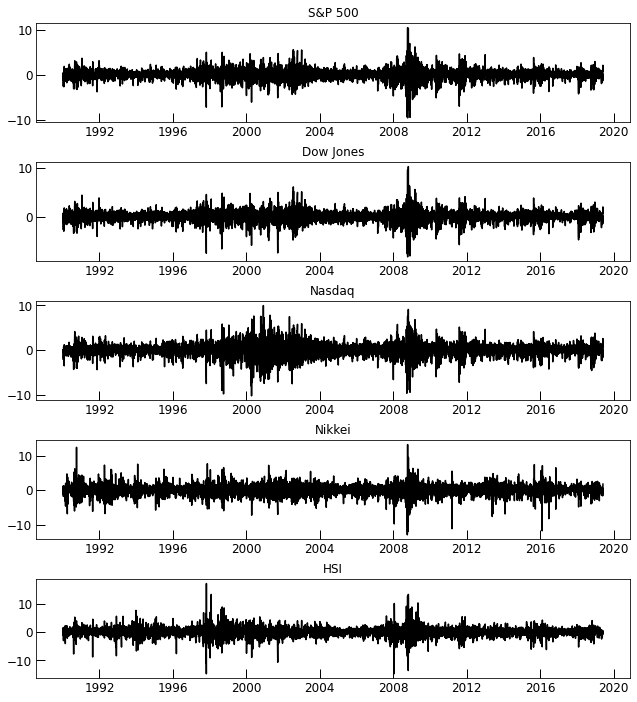

In [7]:
plt.figure(figsize=(15,13))

for i in enumerate(stocke_name):
    ax = plt.subplot(5, 1, i[0]+1)
    plt.plot(Y.index, Y[i[1]], color="black")
    plt.title(i[1])
    ax.tick_params(direction='in', which='both', length=9, width=1, labelsize=12)
    
plt.subplots_adjust(top=0.8, bottom=0.1, left=0.2, right=0.75, hspace=0.4, wspace=0.2)

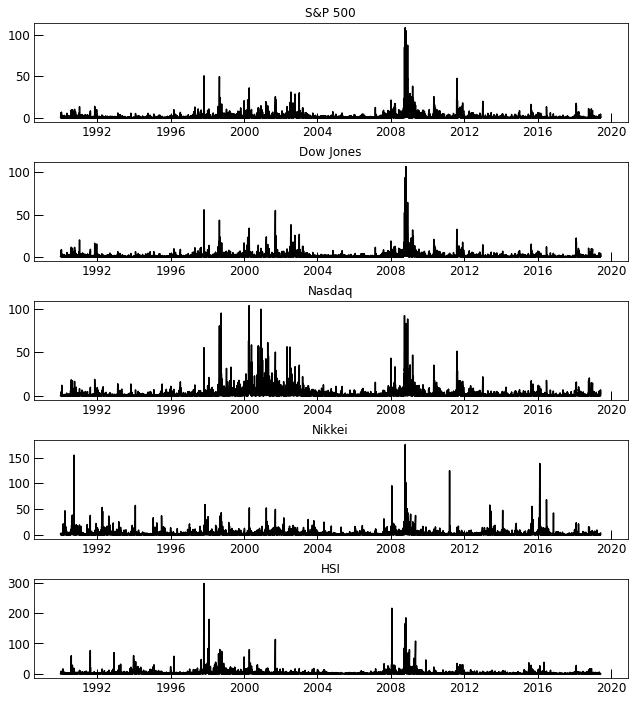

In [8]:
plt.figure(figsize=(15,13))

for i in enumerate(stocke_name):
    ax = plt.subplot(5, 1, i[0]+1)
    plt.plot(volat.index, volat[i[1]], color="black")
    plt.title(i[1])
    ax.tick_params(direction='in', which='both', length=9, width=1, labelsize=12)
    
plt.subplots_adjust(top=0.8, bottom=0.1, left=0.2, right=0.75, hspace=0.4, wspace=0.2)

### Hechos estilizados de las series financieras

1. No autocorrelación en los retornos ($\rho = 0$)

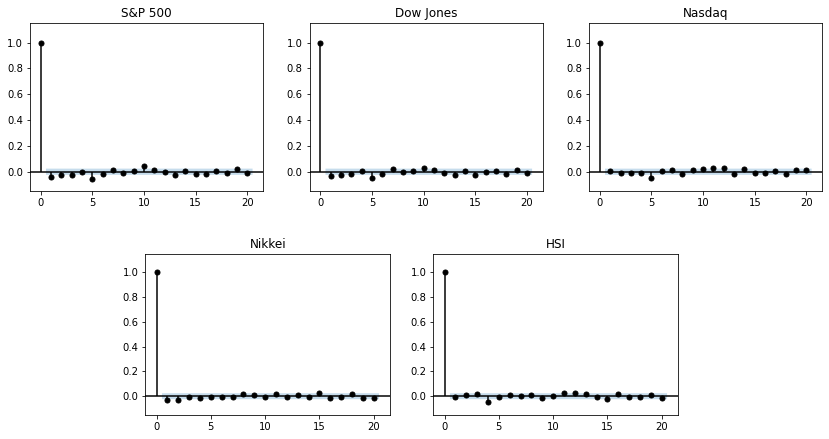

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(20, 8))
ax[1][2].set_visible(False) # No habrá 6to subplot

x, y = [0, 0]

for i in stocke_name:
    plot_acf(Y[i], lags=20, ax=ax[x, y], color="black", vlines_kwargs={"colors": "black"})
    ax[x, y].set_ylim(-0.15, 1.15)
    ax[x, y].set_title(i)
    
    y += 1
    if y == 3:
        x+=1
        y=0

plt.subplots_adjust(top=0.8, bottom=0.1, left=0.2, right=0.75, hspace=0.4, wspace=0.2)

# Posiciones de los subplots de la segunda fila
ax[1, 0].set_position([0.28, 0.12, 0.17, 0.28]) 
ax[1, 1].set_position([0.48, 0.12, 0.17, 0.28])

plt.show()

2. Autocorrelación en los retornos al cuadrado / volatilidad

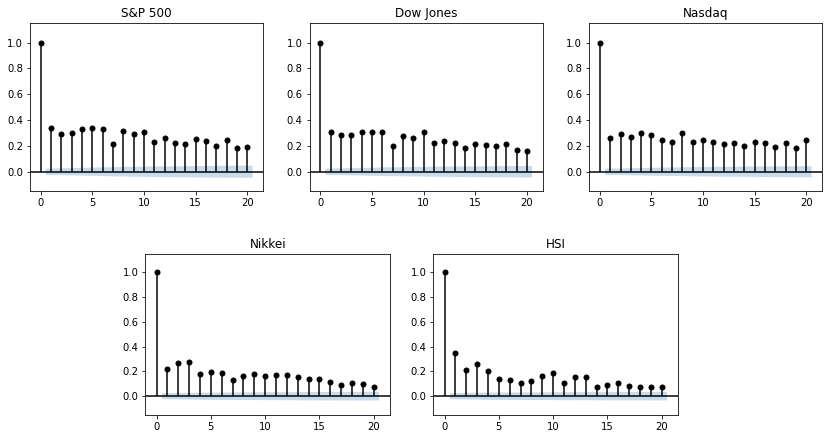

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(20, 8))
ax[1, 2].set_visible(False) # No habrá 6to subplot

x, y = [0, 0]

for i in stocke_name:
    plot_acf(volat[i], lags=20, ax=ax[x, y], color="black", vlines_kwargs={"colors": "black"})
    ax[x, y].set_ylim(-0.15, 1.15)
    ax[x, y].set_title(i)
    
    y += 1
    if y == 3:
        x+=1
        y=0

plt.subplots_adjust(top=0.8, bottom=0.1, left=0.2, right=0.75, hspace=0.4, wspace=0.2)

# Posiciones de los subplots de la segunda fila
ax[1, 0].set_position([0.28, 0.12, 0.17, 0.28])
ax[1, 1].set_position([0.48, 0.12, 0.17, 0.28])

plt.show()

### Determinar la presencia de efectos ARCH

### Estimando el modelo ARCH

Un modelo ARCH tiene, según la propuesta de Robert Engle, un modelo autorregresivo de orden adecuado en los cuadrados de los errores del proceso $y_t$, dado por:
$$
y_t = \phi_0 + \phi_1 y_{t-1} + \epsilon_t
$$

Donde la varianza de condicional de los errroes $\epsilon_t$ dada la información en $\Omega_{t-1}$:
$$
Var(\epsilon_t/\Omega_{t-1}) = E(\epsilon^2_t/\Omega_{t-1}) = \alpha_0 + \alpha_1 \epsilon^2_{t-1} + \alpha_2 \epsilon^2_{t-2}+ ... + \alpha_m \epsilon^2_{t-m}
$$

Del que surge del proceso: 
$$
\epsilon^2_{t} = \alpha_0 + \alpha_1 \epsilon^2_{t-1} + \alpha_2 \epsilon^2_{t-2}+ ... + \alpha_m \epsilon^2_{t-m} + V_t
$$

Mediante iteraciones hacia el futuro, se puede construir la siguiente ecuación:
$$
\epsilon_{t} = V_t \sqrt((\alpha_0 + \alpha_1 \epsilon^2_{t-1} + \alpha_2 \epsilon^2_{t-2}+ ... + \alpha_m \epsilon^2_{t-m}))
$$

Finalmente, se construye las dos ecuaciones del modelo:
$$
\epsilon_{t} =  V_t \sqrt(h_t)
$$

$$
h_{t} = \alpha_0 + \sum^{m}_{i=1} \alpha_i \epsilon^2_{t-i}
$$

In [11]:
arch_1 = arch_model(Y["S&P 500"], p=1, q=0)
arch_1_fit = arch_1.fit(disp=0)
arch_1_fit

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                S&P 500   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -9992.37
Distribution:                  Normal   AIC:                           19990.7
Method:            Maximum Likelihood   BIC:                           20011.2
                                        No. Observations:                 6684
Date:                Sun, Jul 24 2022   Df Residuals:                     6683
Time:                        17:09:03   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0397  1.421e-02      2.796  5.181e-03 [1.

In [12]:
arch_2 = arch_model(Y["S&P 500"], p=2, q=0)
arch_2_fit = arch_2.fit(disp=0)
arch_2_fit

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                S&P 500   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -9627.79
Distribution:                  Normal   AIC:                           19263.6
Method:            Maximum Likelihood   BIC:                           19290.8
                                        No. Observations:                 6684
Date:                Sun, Jul 24 2022   Df Residuals:                     6683
Time:                        17:09:03   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0573  1.215e-02      4.717  2.395e-06 [3.

In [13]:
arch_3 = arch_model(Y["S&P 500"], p=3, q=0)
arch_3_fit = arch_3.fit(disp=0)
arch_3_fit

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                S&P 500   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -9434.96
Distribution:                  Normal   AIC:                           18879.9
Method:            Maximum Likelihood   BIC:                           18913.9
                                        No. Observations:                 6684
Date:                Sun, Jul 24 2022   Df Residuals:                     6683
Time:                        17:09:03   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0662  1.120e-02      5.915  3.315e-09 [4.

In [14]:
arch_4 = arch_model(Y["S&P 500"], p=4, q=0)
arch_4_fit = arch_4.fit(disp=0)
arch_4_fit

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                S&P 500   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -9278.54
Distribution:                  Normal   AIC:                           18569.1
Method:            Maximum Likelihood   BIC:                           18609.9
                                        No. Observations:                 6684
Date:                Sun, Jul 24 2022   Df Residuals:                     6683
Time:                        17:09:03   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0647  1.056e-02      6.125  9.073e-10 [4.

### Estimando el modelo GARCH

El modelo GARCH es un ARCH Generalizado, donde un GARCH(1, 1) se puede aproximar como un ARCH($\inf$)

In [15]:
garch_11 = arch_model(Y["S&P 500"], p=1, q=1)
garch_11_fit = garch_11.fit(disp=0)
garch_11_fit

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                S&P 500   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9090.16
Distribution:                  Normal   AIC:                           18188.3
Method:            Maximum Likelihood   BIC:                           18215.5
                                        No. Observations:                 6684
Date:                Sun, Jul 24 2022   Df Residuals:                     6683
Time:                        17:09:04   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0587  1.026e-02      5.720  1.065e-08 [3.

In [16]:
garch_21 = arch_model(Y["S&P 500"], p=2, q=1)
garch_21_fit = garch_21.fit(disp=0)
garch_21_fit

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                S&P 500   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9087.44
Distribution:                  Normal   AIC:                           18184.9
Method:            Maximum Likelihood   BIC:                           18218.9
                                        No. Observations:                 6684
Date:                Sun, Jul 24 2022   Df Residuals:                     6683
Time:                        17:09:04   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0592  1.026e-02      5.769  7.991e-09 [3.

In [17]:
garch_12 = arch_model(Y["S&P 500"], p=1, q=2)
garch_12_fit = garch_12.fit(disp=0)
garch_12_fit

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                S&P 500   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9090.16
Distribution:                  Normal   AIC:                           18190.3
Method:            Maximum Likelihood   BIC:                           18224.4
                                        No. Observations:                 6684
Date:                Sun, Jul 24 2022   Df Residuals:                     6683
Time:                        17:09:04   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0587  1.029e-02      5.700  1.201e-08 [3.

In [18]:
garch_22 = arch_model(Y["S&P 500"], p=2, q=2)
garch_22_fit = garch_22.fit(disp=0)
garch_22_fit

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                S&P 500   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9085.50
Distribution:                  Normal   AIC:                           18183.0
Method:            Maximum Likelihood   BIC:                           18223.8
                                        No. Observations:                 6684
Date:                Sun, Jul 24 2022   Df Residuals:                     6683
Time:                        17:09:04   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0589  1.037e-02      5.677  1.372e-08 [3.

### Determinar el mejor modelo según criterios de información

#### BIC (Bayesian Information Criterio)
Para determinar el mejor mejor modelo, se puede estimar los criterios de información. Aquel que posea el menor nivel de BIC, será el seleccionado:

In [19]:
print(f"BIC for ARCH(1): {np.round(arch_1_fit.bic, 3)}")
print(f"BIC for ARCH(2): {np.round(arch_2_fit.bic, 3)}")
print(f"BIC for ARCH(3): {np.round(arch_3_fit.bic, 3)}")
print(f"BIC for ARCH(4): {np.round(arch_4_fit.bic, 3)}")
print(f"BIC for GARCH(1, 1): {np.round(garch_11_fit.bic, 3)}")
print(f"BIC for GARCH(1, 2): {np.round(garch_12_fit.bic, 3)}")
print(f"BIC for GARCH(2, 1): {np.round(garch_21_fit.bic, 3)}")
print(f"BIC for GARCH(2, 2): {np.round(garch_22_fit.bic, 3)}")

BIC for ARCH(1): 20011.165
BIC for ARCH(2): 19290.811
BIC for ARCH(3): 18913.95
BIC for ARCH(4): 18609.916
BIC for GARCH(1, 1): 18215.547
BIC for GARCH(1, 2): 18224.355
BIC for GARCH(2, 1): 18218.92
BIC for GARCH(2, 2): 18223.837


#### AIC (Akaike Information Criterio)

In [20]:
print(f"BIC for ARCH(1): {np.round(arch_1_fit.aic, 3)}")
print(f"BIC for ARCH(2): {np.round(arch_2_fit.aic, 3)}")
print(f"BIC for ARCH(3): {np.round(arch_3_fit.aic, 3)}")
print(f"BIC for ARCH(4): {np.round(arch_4_fit.aic, 3)}")
print(f"BIC for GARCH(1, 1): {np.round(garch_11_fit.aic, 3)}")
print(f"BIC for GARCH(1, 2): {np.round(garch_12_fit.aic, 3)}")
print(f"BIC for GARCH(2, 1): {np.round(garch_21_fit.aic, 3)}")
print(f"BIC for GARCH(2, 2): {np.round(garch_22_fit.aic, 3)}")

BIC for ARCH(1): 19990.742
BIC for ARCH(2): 19263.581
BIC for ARCH(3): 18879.913
BIC for ARCH(4): 18569.071
BIC for GARCH(1, 1): 18188.317
BIC for GARCH(1, 2): 18190.317
BIC for GARCH(2, 1): 18184.883
BIC for GARCH(2, 2): 18182.992


El mejor modelo, tanto por BIC como por AIC, es un GARCH(1,1), pero también se podría presentar un modelo GARCH(2,1)

### Plotting

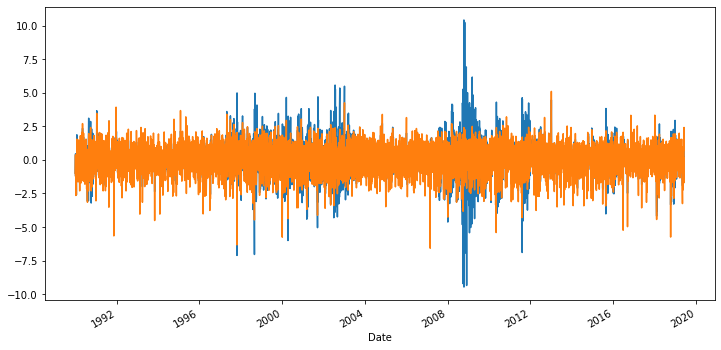

In [21]:
Y["S&P 500"].plot(figsize=(12,6))
garch_11_fit.std_resid.plot()

plt.show()

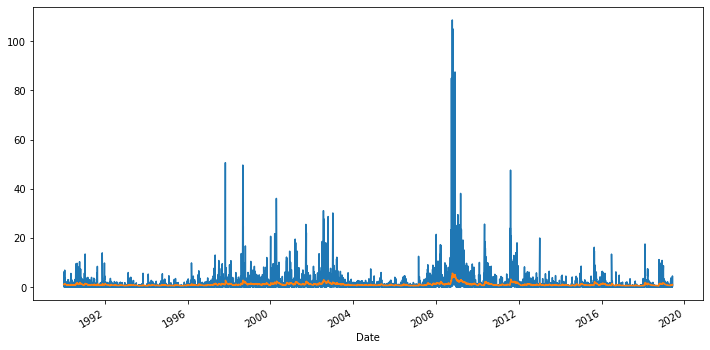

In [22]:
volat["S&P 500"].plot(figsize=(12,6))
garch_11_fit.conditional_volatility.plot()

plt.show()